<a href="https://colab.research.google.com/github/danfolador/REDES/blob/main/REDES_Exercicio01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**EXERCÍCIO 01**

Aluno: Daniel Folador Rossi

Matrícula: 20201mpca0306

---

Considere um dataset de 2 dimensões em que todos os pontos com
x1 > x2 pertencem à classe positiva, e todos os pontos com x1 <= x2
pertencem à classe negativa. Assim, o separador entre as duas classes
é um hiperplano linear definido por x1 - x2 = 0. Agora crie um dataset
com 20 pontos aleatoriamente gerados dentro de uma unidade quadrada no
quadrante positivo. Rotule cada ponto dependendo se x1 é maior do
que x2, ou não.

1. Implemente o algoritmo perceptron sem regularização. Treino-o com os 20 pontos gerados, e teste sua acurácia com 1000 pontos gerados aleatoriamente dentro da unidade quadrada. Gere os pontos de teste usando o mesmo procedimento usado para gerar os dados de treino.

2. Mude o critério do perceptron para hinge-loss na sua implementação. Repita o treino e a estimativa de acurácia com os mesmo pontos do item anterior.

3. Em qual caso você obteve a melhor acurácia, e por quê?

4. Em qual caso você acha que a classificação dos mesmos 1000 pontos de teste não será significativamente diferente se o algoritmo for treinado com 20 pontos diferentes, também gerados aleatoriamente?

In [31]:
#======================================================
# INICIALIZAÇÃO
#======================================================
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
 

In [32]:
#======================================================
# FUNCOES DE BANCO DE DADOS
#======================================================
def GeraDataSet(tamanho,seed_fixa=False):
    if seed_fixa:
        rng = np.random.default_rng(1)
        X = rng.uniform(size=(tamanho,2))   
    else:
        X = np.random.uniform(size=(tamanho,2))   

    #Classes -1 ou 1
    y = np.array(X[:,0]>X[:,1], dtype=int)*2-1
    
    return X, y

def PlotaDataSet(X,y,alpha,label):
    #plota pra cada classe
    for k in [-1,1]:#set(y):
        logic = y==k
        plt.plot(X[:,0][logic], X[:,1][logic], 'o', alpha=alpha, label=label)
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.xlim([-0.1,1.1])
    plt.ylim([-0.1,1.1])
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


def PlotaVetor(vetor, cor='k', alpha=1.0):
    origem= [0,0]
    plt.arrow(*origem, *vetor, color=cor, alpha=alpha)
    

def Perpendicular(vetor):
    perpend = np.array(vetor[::-1])
    perpend[0] *= -1
    return perpend

In [33]:
#======================================================
# PERCEPTRON
#======================================================
from sklearn.base import BaseEstimator, ClassifierMixin

class CustoPerceptron():
    @staticmethod
    def Erro(y, ypred):
        return y - ypred
    @staticmethod
    def Custo(y, ypred):
        return np.sum(CustoPerceptron.Erro(y, ypred)**2) #chamada de Sum of Squared Errors (SSE)
    @staticmethod
    def Gradiente(y, ypred, X):
        return np.matmul(CustoPerceptron.Erro(y, ypred),X)
    
class HingeLoss():
    @staticmethod
    def Erro(y, ypred):
        return np.multiply(y, ypred)
    @staticmethod
    def Custo(y, ypred):
        return np.sum(1 - HingeLoss.Erro(y, ypred))
    @staticmethod
    def Gradiente(y, ypred, X):
        marginais = HingeLoss.Erro(y, ypred) < 1
        return np.matmul(y[marginais],X[marginais])
    
class Perceptron(BaseEstimator, ClassifierMixin):
    def __init__(self, fcusto=CustoPerceptron()):
        
        # Inicia o vetor de pesos
        self.w= None
        
        # Funcao de ativacao
        self.activation = lambda a: (a>=0)*2 -1
        
        # Taxa de aprendizado
        self.alpha =0.1
        
        # Máximo de iteracoes
        # O Perceptron sempre converge para bases linearmente separadas,
        # Se não for o caso, vai parar com 100 iteracoes
        self.maxiter = 100
        
        # Função de custo
        self.fcusto = fcusto
        
    def fit(self,X,y):
        
        # Vetor de pesos inicial (aleatório)
        self.w = np.random.uniform(-1,1,size=2)
        
        # Atualiza o vetor de pesos
        # (função de custo hingeloss)
        for _  in range(self.maxiter):
            ypred = self.predict(X)
            custo = self.fcusto.Custo(y,ypred)
            self.w = self.w + (self.alpha)*(self.fcusto.Gradiente(y,ypred,X))
            
            if custo==0:
                break
        
    def predict(self,X):
        a = np.matmul(X, self.w)
        ypred = self.activation(a)
        return ypred

In [34]:
#======================================================
# BANCO DE DADOS
#======================================================
# Hiperplano correto
vetor=[1,-1]                     # Vetor perpendicular ao hiperplano separador
hiperplano= Perpendicular(vetor) # Hiperplano separador das classes -1/+1
     
# Gera dados de teste
Xtest, ytest = GeraDataSet(1000,seed_fixa=True)

#Plota dados
data = np.stack((Xtest[:,0],Xtest[:,1],ytest)).T
df = pd.DataFrame(data)
print('============================')
print('DADOS DE TESTE')
print('============================')
print(df.head(10))
print()


DADOS DE TESTE
          0         1    2
0  0.511822  0.950464 -1.0
1  0.144160  0.948649 -1.0
2  0.311831  0.423326 -1.0
3  0.827703  0.409199  1.0
4  0.549594  0.027559  1.0
5  0.753513  0.538143  1.0
6  0.329732  0.788429 -1.0
7  0.303195  0.453498 -1.0
8  0.134042  0.403113 -1.0
9  0.203455  0.262313 -1.0



In [35]:
#======================================================
# FUNCAO AJUSTE PERCEPTRON
#======================================================
def Ajuste(titulo, Xtrain, ytrain, Xtest, ytest, fcusto):
    perceptron = Perceptron(fcusto=fcusto)
    
    perceptron.fit(Xtrain, ytrain)
    ypred = perceptron.predict(Xtest)          #Prediçao com resubstituição
    acuracia = sum(ytest==ypred)/len(ytest)    #Acuacia
    vetor_pred = perceptron.w
    hiperplano_pred = Perpendicular(vetor_pred)
    
    
    # PLOT DE RESULTADOS
    #------------------------------------------------------
    plt.title(titulo)
    plt.annotate('acuracia= '+str(acuracia), (0,1.025), color='red')
    PlotaDataSet(Xtest, ytest, alpha=0.3, label='Teste')
    PlotaDataSet(Xtrain, ytrain, alpha=1.0, label='Treino')
    PlotaVetor(hiperplano, cor='grey')
    PlotaVetor(hiperplano_pred, cor='k')
    plt.show()
    
    return acuracia

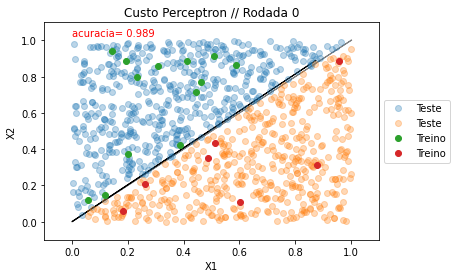

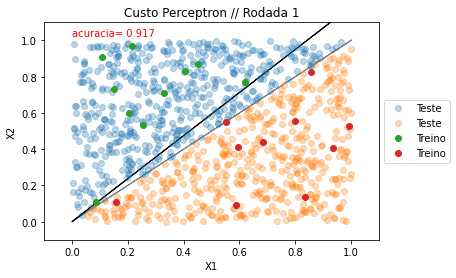

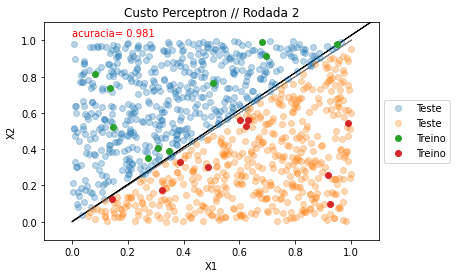

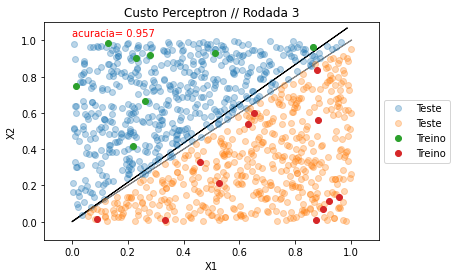

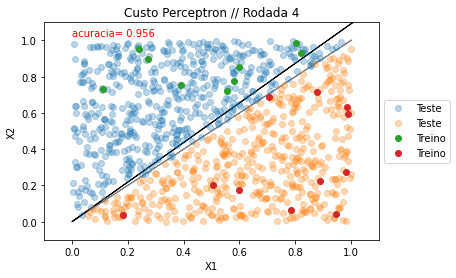

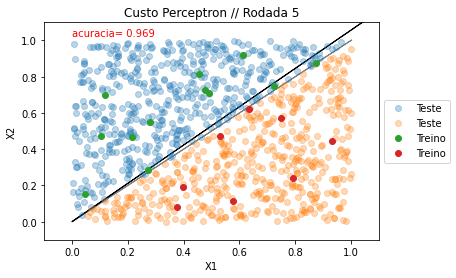

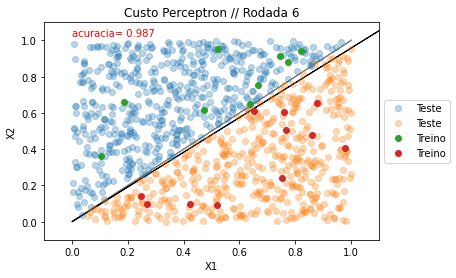

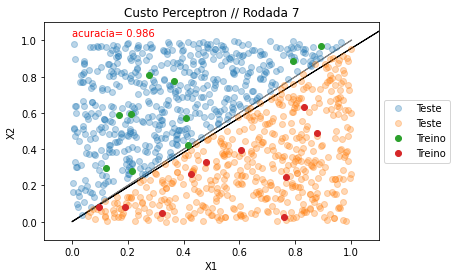

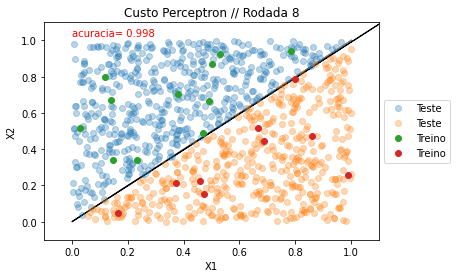

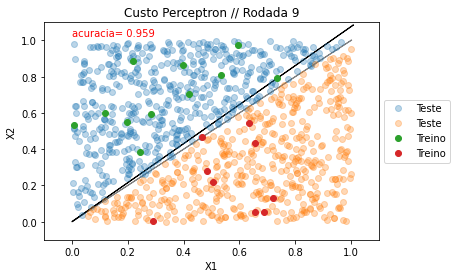

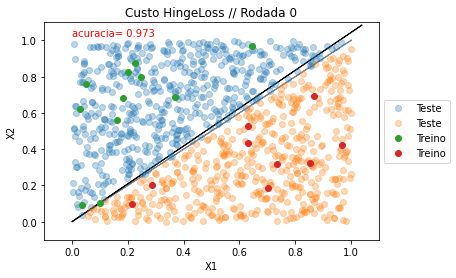

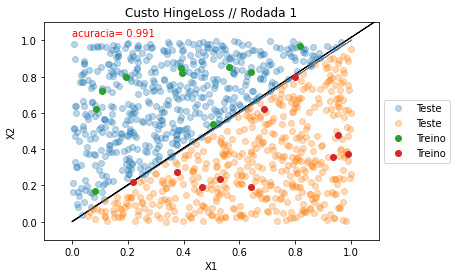

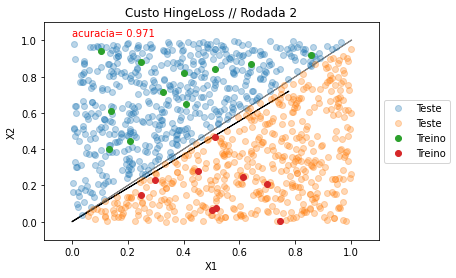

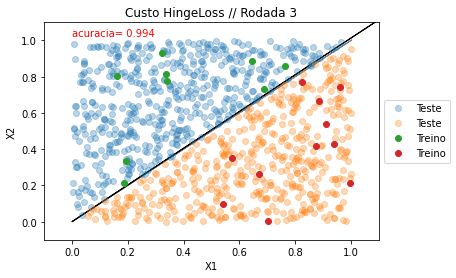

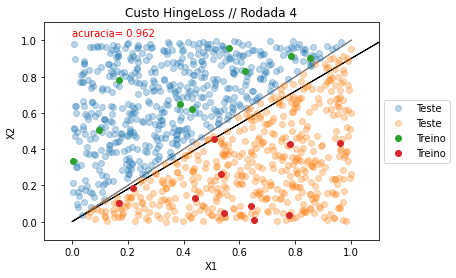

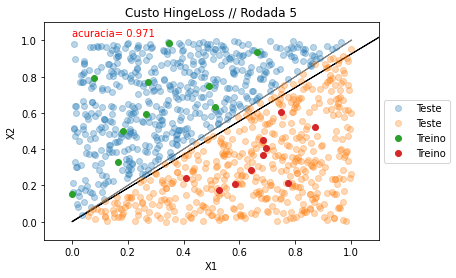

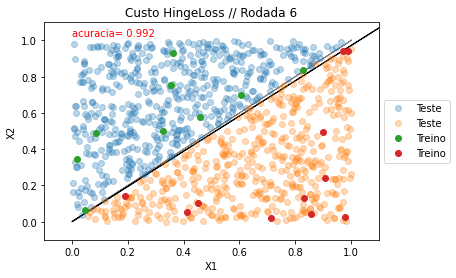

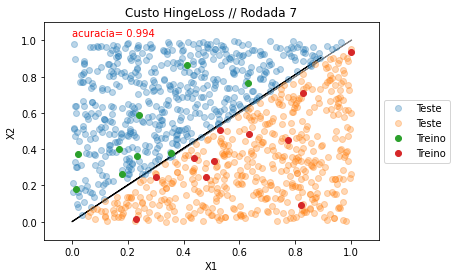

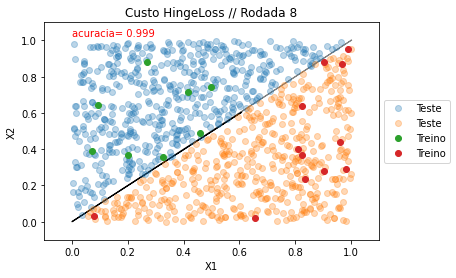

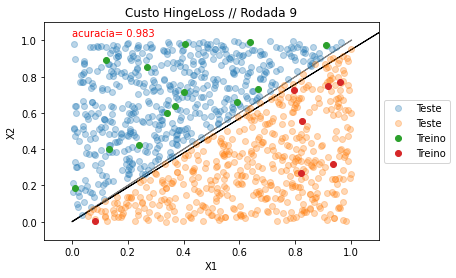

ACURACIA CUSTO PERCEPTRON
     0      1
0  0.0  0.989
1  1.0  0.917
2  2.0  0.981
3  3.0  0.957
4  4.0  0.956
5  5.0  0.969
6  6.0  0.987
7  7.0  0.986
8  8.0  0.998
9  9.0  0.959
MÉDIA=   0.9699

ACURACIA CUSTO HINGELOSS
     0      1
0  0.0  0.973
1  1.0  0.991
2  2.0  0.971
3  3.0  0.994
4  4.0  0.962
5  5.0  0.971
6  6.0  0.992
7  7.0  0.994
8  8.0  0.999
9  9.0  0.983
MÉDIA=   0.983



In [36]:
#======================================================
# RODADAS
#======================================================
rodadas=10

# Custo Perceptron
#-------------------------
arr_acc1=[]
for i in range(rodadas):
    titulo="Custo Perceptron // Rodada "+str(i)
    Xtrain, ytrain = GeraDataSet(20,seed_fixa=False)
    acuracia = Ajuste(titulo, Xtrain, ytrain, Xtest, ytest, fcusto=CustoPerceptron())
    arr_acc1.append(acuracia)


# Hingeloss
#-------------------------
arr_acc2=[]
for i in range(rodadas):
    titulo="Custo HingeLoss // Rodada "+str(i)
    Xtrain, ytrain = GeraDataSet(20,seed_fixa=False)
    acuracia = Ajuste(titulo, Xtrain, ytrain, Xtest, ytest, fcusto=CustoPerceptron())
    arr_acc2.append(acuracia)


print('============================')
print('ACURACIA CUSTO PERCEPTRON')
print('============================')
data = range(rodadas), arr_acc1
df = pd.DataFrame(data).T
print(df)
print('MÉDIA=  ', np.mean(arr_acc1))
print()

print('============================')
print('ACURACIA CUSTO HINGELOSS')
print('============================')
data = range(rodadas), arr_acc2
df = pd.DataFrame(data).T
print(df)
print('MÉDIA=  ', np.mean(arr_acc2))
print()

# Conclusões

Foram feitas dez rodadas com 20 pontos de treino aleatórios e testados para os mesmo 1.000 pontos de teste. Foi obtida a melhor acurácia média para a função de custo Hinge Loss.

Isso ocorreu porque a função Hinge Loss penaliza não só as classificações incorretas, mas também aquelas que estão corretas mas tem pouca confiabilidade (por estarem muito próximas do hiperplano separador.